# 1. 활성화 함수 선택 기능 추가 및 성능 비교

In [1]:
# 곱셈 계층 
class MulLayer:
    def __init__(self):
        self.x = None
        self.y = None

    def forward(self, x, y):
        self.x = x
        self.y = y
        out = x * y
        return out

    def backward(self, dout):
        dx = self.y * dout
        dy = self.x * dout
        return dx, dy

# 덧셈 계층
class AddLayer:
    def __init__(self):
        pass

    def forward(self, x, y):
        out = x + y
        return out

    def backward(self, dout):
        dx = dout * 1
        dy = dout * 1
        return dx, dy

# 렐루 계층
class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0
        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout
        return dx

# 시그모이드 계층 
class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        self.out = 1 / (1 + np.exp(-x))
        return self.out

    def backward(self, dout):
        dx = dout * (1 - self.out) * self.out
        return dx

def cross_entropy_error(p, r):
    delta = 1e-7
    return -np.sum(r * np.log(p + delta))

def numerical_gradient(f, x):
    h = 1e-4
    grad = np.zeros_like(x)

    for idx in np.ndindex(x.shape):
        tmp_val = x[idx]
        
        x[idx] = tmp_val + h
        fxh1 = f(x)

        x[idx] = tmp_val - h
        fxh2 = f(x)

        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val
    
    return grad

def softmax(x):
    if x.ndim == 1:
        c = np.max(x)
        exp_a = np.exp(x-c)
        sum_exp_a = np.sum(exp_a)
        y = exp_a / sum_exp_a
        return y
    elif x.ndim == 2:
        c = np.max(x, axis = 1).reshape(-1, 1)
        exp_a = np.exp(x - c)
        sum_exp_a = np.sum(exp_a, axis = 1).reshape(-1, 1)
        y = exp_a / sum_exp_a
        return y

# 소프트맥스 계층
class SoftmaxLoss:
    def __init__(self):
        self.loss = None
        self.y = None
        self.t = None

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        return self.loss

    def backward(self, dout):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size
        return dx

# 어파인 계층 
class Affine:
    def __init__(self, w, b):
        self.w = w
        self.b = b
        self.x = None
        self.dw = None
        self.db = None

    def forward(self, x):
        self.x = x
        out = x @ self.w + self.b
        return out

    def backward(self, dout):
        dx = dout @ self.w.T
        self.dw = self.x.T @ dout
        self.db = np.sum(dout, axis = 0)
        return dx

## ReLU 사용

In [2]:
from collections import OrderedDict
import numpy as np

class TwoLayerNet:
    def __init__(self, I, H, O):
        self.params = {}
        self.params['w1'] = np.random.randn(I, H)
        self.params['b1'] = np.random.randn(H)
        self.params['w2'] = np.random.randn(H, O)
        self.params['b2'] = np.random.randn(O)

        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['w1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['w2'], self.params['b2'])
        self.last_layer = SoftmaxLoss()

    def predict(self, x):
        for i in self.layers.values():
            x = i.forward(x)
        return x

    def loss(self, x, t):
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis = 1)
        accuracy = np.sum(y == t) / x.shape[0]
        return accuracy

    def numerical_gradient(self, x, t):
        loss_w = lambda w : self.loss(x, t)
        grads = {}
        grads['w1'] = numerical_gradient(loss_w, self.params['w1'])
        grads['b1'] = numerical_gradient(loss_w, self.params['b1'])
        grads['w2'] = numerical_gradient(loss_w, self.params['w2'])
        grads['b2'] = numerical_gradient(loss_w, self.params['b2'])
        return grads

    def gradient(self, x, t):
        self.loss(x, t)

        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()

        for i in layers:
            dout = i.backward(dout)

        grads = {}
        grads['w1'] = self.layers['Affine1'].dw
        grads['b1'] = self.layers['Affine1'].db
        grads['w2'] = self.layers['Affine2'].dw
        grads['b2'] = self.layers['Affine2'].db
        return grads

In [3]:
import pickle
f = open("Data/mnist.dat", 'rb')
train, test = pickle.load(f)
f.close()

train_x, train_y = train
test_x, test_y = test

train_scaled = train_x.reshape(-1, 784) / 255
test_scaled = test_x.reshape(-1, 784) / 255

from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
train_y = encoder.fit_transform(train_y.reshape(-1, 1)).toarray()
test_y = encoder.fit_transform(test_y.reshape(-1, 1)).toarray()

In [4]:
from tqdm import tqdm

net = TwoLayerNet(784, 500, 10)

train_losses = []
test_losses = []

for i in tqdm(range(1000)):
    mask = np.random.choice(60000, 100)
    x_batch = train_scaled[mask]
    t_batch = train_y[mask]

    grad = net.gradient(x_batch, t_batch)

    for key in ('w1', 'b1', 'w2', 'b2'):
        net.params[key] -= grad[key] * 0.1

    loss = net.loss(x_batch, t_batch)
    test_loss = net.loss(test_scaled, test_y)

    train_losses.append(loss)
    test_losses.append(test_loss)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:15<00:00,  7.40it/s]


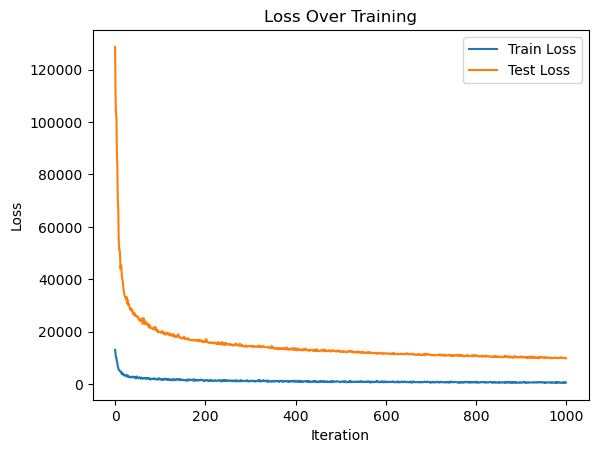

In [13]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Training')
plt.show()

In [14]:
train_acc = net.accuracy(train_scaled, np.argmax(train_y, axis=1))
test_acc = net.accuracy(test_scaled, np.argmax(test_y, axis=1))
print(f"Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")

Train Accuracy: 0.9411, Test Accuracy: 0.9218


## Sigmoid 사용 

In [15]:
from collections import OrderedDict
import numpy as np

class TwoLayerNet:
    def __init__(self, I, H, O):
        self.params = {}
        self.params['w1'] = np.random.randn(I, H)
        self.params['b1'] = np.random.randn(H)
        self.params['w2'] = np.random.randn(H, O)
        self.params['b2'] = np.random.randn(O)

        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['w1'], self.params['b1'])
        self.layers['Sigmoid'] = Sigmoid()
        self.layers['Affine2'] = Affine(self.params['w2'], self.params['b2'])
        self.last_layer = SoftmaxLoss()

    def predict(self, x):
        for i in self.layers.values():
            x = i.forward(x)
        return x

    def loss(self, x, t):
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis = 1)
        accuracy = np.sum(y == t) / x.shape[0]
        return accuracy

    def numerical_gradient(self, x, t):
        loss_w = lambda w : self.loss(x, t)
        grads = {}
        grads['w1'] = numerical_gradient(loss_w, self.params['w1'])
        grads['b1'] = numerical_gradient(loss_w, self.params['b1'])
        grads['w2'] = numerical_gradient(loss_w, self.params['w2'])
        grads['b2'] = numerical_gradient(loss_w, self.params['b2'])
        return grads

    def gradient(self, x, t):
        self.loss(x, t)

        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()

        for i in layers:
            dout = i.backward(dout)

        grads = {}
        grads['w1'] = self.layers['Affine1'].dw
        grads['b1'] = self.layers['Affine1'].db
        grads['w2'] = self.layers['Affine2'].dw
        grads['b2'] = self.layers['Affine2'].db
        return grads

In [16]:
from tqdm import tqdm

net = TwoLayerNet(784, 500, 10)

train_losses = []
test_losses = []

for i in tqdm(range(1000)):
    mask = np.random.choice(60000, 1000)
    x_batch = train_scaled[mask]
    t_batch = train_y[mask]

    grad = net.gradient(x_batch, t_batch)

    for key in ('w1', 'b1', 'w2', 'b2'):
        net.params[key] -= grad[key] * 0.1

    loss = net.loss(x_batch, t_batch)
    test_loss = net.loss(test_scaled, test_y)

    train_losses.append(loss)
    test_losses.append(test_loss)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:12<00:00,  5.20it/s]


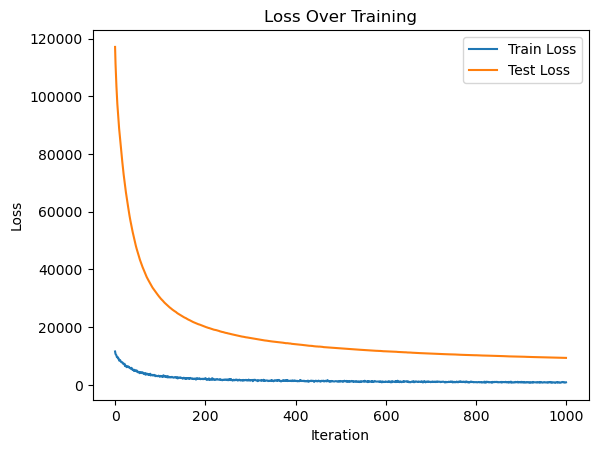

In [17]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Training')
plt.show()

In [18]:
train_acc = net.accuracy(train_scaled, np.argmax(train_y, axis=1))
test_acc = net.accuracy(test_scaled, np.argmax(test_y, axis=1))
print(f"Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")

Train Accuracy: 0.8472, Test Accuracy: 0.8414


ReLU를 사용했을 때의 학습 정확도, 테스트 정확도가 더 높은 성능을 보였다.    
=> sigmoid와 달리 Relu는 기울기 소실 문제가 발생하지 않아 학습이 빠르기 때문에   
sigmoid 활성화 함수를 사용했을 때보다 ReLU 활성화 함수를 사용하였을 때 더 좋은 성능을 나타낸 것이라고 추측된다.

# 2. 은닉층 하나 더 추가하여 3계층 신경망 구현 및 실험

In [21]:
from collections import OrderedDict
import numpy as np

class ThreeLayerNet:
    def __init__(self, I, H1, H2, O):
        self.params = {}
        self.params['w1'] = np.random.randn(I, H1) * 0.01
        self.params['b1'] = np.zeros(H1)
        self.params['w2'] = np.random.randn(H1, H2) * 0.01
        self.params['b2'] = np.zeros(H2)
        self.params['w3'] = np.random.randn(H2, O) * 0.01
        self.params['b3'] = np.zeros(O)

        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['w1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['w2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine3'] = Affine(self.params['w3'], self.params['b3'])
        self.last_layer = SoftmaxLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x

    def loss(self, x, t):
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        accuracy = np.sum(y == t) / x.shape[0]
        return accuracy

    def numerical_gradient(self, x, t):
        loss_w = lambda w: self.loss(x, t)
        grads = {}
        grads['w1'] = numerical_gradient(loss_w, self.params['w1'])
        grads['b1'] = numerical_gradient(loss_w, self.params['b1'])
        grads['w2'] = numerical_gradient(loss_w, self.params['w2'])
        grads['b2'] = numerical_gradient(loss_w, self.params['b2'])
        grads['w3'] = numerical_gradient(loss_w, self.params['w3'])
        grads['b3'] = numerical_gradient(loss_w, self.params['b3'])
        return grads

    def gradient(self, x, t):
        self.loss(x, t)

        dout = 1
        dout = self.last_layer.backward(dout)

        for layer in reversed(list(self.layers.values())):
            dout = layer.backward(dout)

        grads = {}
        grads['w1'] = self.layers['Affine1'].dw
        grads['b1'] = self.layers['Affine1'].db
        grads['w2'] = self.layers['Affine2'].dw
        grads['b2'] = self.layers['Affine2'].db
        grads['w3'] = self.layers['Affine3'].dw
        grads['b3'] = self.layers['Affine3'].db
        return grads

In [22]:
net = ThreeLayerNet(784, 256, 128, 10)

train_losses = []
test_losses = []

for i in tqdm(range(1000)):
    mask = np.random.choice(len(train_scaled), 100)
    x_batch = train_scaled[mask]
    t_batch = train_y[mask]

    grad = net.gradient(x_batch, t_batch)

    for key in net.params:
        net.params[key] -= grad[key] * 0.1

    loss = net.loss(x_batch, t_batch)
    test_loss = net.loss(test_scaled, test_y)

    train_losses.append(loss)
    test_losses.append(test_loss)


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:44<00:00,  9.58it/s]


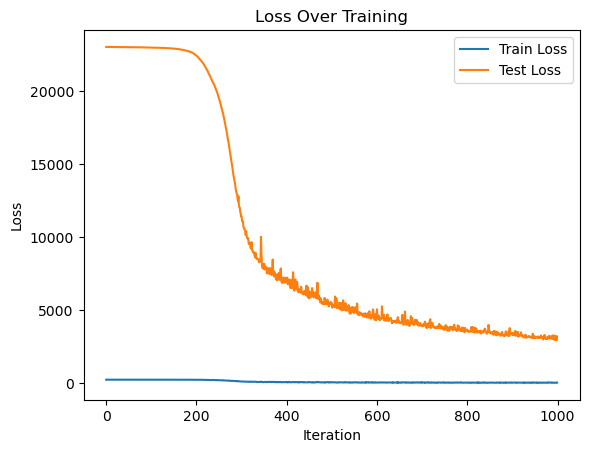

In [23]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Training')
plt.show()

In [24]:
train_acc = net.accuracy(train_scaled, np.argmax(train_y, axis=1))
test_acc = net.accuracy(test_scaled, np.argmax(test_y, axis=1))
print(f"Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")

Train Accuracy: 0.9055, Test Accuracy: 0.9049


2계층 모델의 성능은 Train Accuracy: 0.9411, Test Accuracy: 0.9218이므로   
2계층 모델 대비 3계층 모델의 성능이 저하됨을 확인할 수 있다.